# ***Importing the libraries***

In [163]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from random import randint

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from xgboost import XGBRegressor, plot_importance


# ***Defining functions***

In [164]:
COLORS = ['#8c1b3f','#fe0151', '#0c7ff4', '#3eb1ff']
CMAP = LinearSegmentedColormap.from_list('my_cmap', COLORS)

def print_regression_report(x_test, y_test, model, title):
    y_hat = truncate_prediction(model, x_test)
    
    print(f'{"="*53}\n{title}\n{"="*53}')
    print('Mean Squared Error:\t\t', mean_squared_error(y_test, y_hat))
    print('Mean Absolute Error:\t\t', mean_absolute_error(y_test, y_hat))
    print('R²:\t\t\t\t', r2_score(y_test, y_hat))
    print('Root Mean Squared Error:\t', np.sqrt(mean_squared_error(y_test, y_hat)))
    
    
def plot_residual_distribution(x_test, y_test, model, title):
    residuals = y_test - truncate_prediction(model, x_test)
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(residuals, color=COLORS[2], kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'})
    ax.set_title(f'Residuals distribution - {title}')
    ax.set_xlabel('Residual value')
    ax.set_ylabel('')
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
    ax.legend();
    
def plot_residual_comparison(x_test, y_test, model, title):
    residuals = y_test - truncate_prediction(model, x_test)
    
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x=y_test, y=residuals, color=COLORS[2], label='Residuals')
    ax.set_title(f'Residuals comparison - {title}')
    ax.set_xlabel('True value')
    ax.set_ylabel('Residual value')
    ax.hlines(0, 0, 1, colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
    ax.hlines(mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', label='MAE', linewidth=2)
    ax.hlines(-mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', linewidth=2)
    ax.legend();
    
def plot_feature_importance(model, x_test):
    explaner = shap.TreeExplainer(model)
    shap_values = explaner.shap_values(x_test)
    shap.summary_plot(shap_values, x_test, plot_type="violin", max_display=10)
    
def predict(model,test, Y, normalizer=MinMaxScaler(), scaler=StandardScaler()):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        try:
            print_input = pd.DataFrame(scaler.inverse_transform(row_input), columns=row_input.columns) # type: ignore
        except:
            print_input = row_input 
    print('Input: ')
    print(f'The combat was between 4 players level {int(print_input.players_level.values[0])} against {int(print_input.num_of_monsters.values[0])} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', Y.iloc[input_test])
    print('Predicted: ', truncate_prediction(model, row_input)[0])
    print(f'Delta: {round(abs(Y.iloc[input_test] - truncate_prediction(model, row_input)[0]), 2)}')

def truncate_prediction(model, x_test):
    y_hat = model.predict(x_test)
    y_hat = np.where(y_hat > 1, 1, y_hat)
    y_hat = np.where(y_hat < 0, 0, y_hat)
    return y_hat

# ***Importing the dataset***

In [165]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)

p1_class  p1_hp  p1_ac  p1_avg_save   p2_class  p2_hp  p2_ac  \
71784   Cleric      7     14            2  Artificer      7     18   
80428     Monk     10     12            2       Monk     11     15   
24943     Bard     29     13            3      Rogue     37     14   
31906  Wizzard     12     14            2      Rogue     14     13   
77664  Warlock     22     16            3    Paladin     25     17   

       p2_avg_save   p3_class  p3_hp  ...  p4_ac  p4_avg_save num_of_monsters  \
71784            2       Bard      7  ...     18            2               1   
80428            2  Artificer     16  ...     16            2              10   
24943            3  Barbarian     50  ...     15            3               2   
31906            2    Fighter     24  ...     13            2               1   
77664            3    Wizzard     20  ...     13            3               2   

                 monster_name  monster_cr  monster_ac  monster_hp  \
71784  Faerie Dragon (Violet)        2.00          15          14   
80428                    Drow        0.25          15          13   
24943             Merrenoloth        3.00          13          40   
31906    Hobgoblin Devastator        4.00          13          45   
77664                Gargoyle        2.00          15          52   

      monster_type  dificulty  players_level  
71784       dragon   1.000000              1  
80428     humanoid   0.000000              2  
24943        fiend   0.969956              4  
31906          fey   0.066463              2  
77664    elemental   0.629516              3  

[5 rows x 24 columns]

In [166]:
df_test = pd.read_csv('../Data/test_sample.csv', encoding='utf-8')
df_test.sample(5)

p1_class  p1_hp  p1_ac  p1_avg_save   p2_class  p2_hp  p2_ac  \
444    Ranger     27     13            3    Paladin     34     16   
372      Monk     34     16            3    Paladin     32     17   
775      Bard     25     15            3  Artificer     31     18   
2743  Fighter     44     19            3       Bard     44     14   
774      Monk     26     12            3       Bard     21     14   

      p2_avg_save   p3_class  p3_hp  ...  p4_ac  p4_avg_save num_of_monsters  \
444             3  Barbarian     27  ...     16            3               1   
372             3    Wizzard     20  ...     13            3              10   
775             3      Rogue     31  ...     10            3               3   
2743            3       Monk     32  ...     11            3              10   
774             3  Barbarian     31  ...     14            3               1   

        monster_name  monster_cr  monster_ac  monster_hp monster_type  \
444            Wight       3.000          14          45       undead   
372          Mastiff       0.125          12           5        beast   
775             Orog       2.000          18          42     humanoid   
2743  Swarm of Wasps       0.500          12          22        beast   
774     Tortle Druid       2.000          17          33     humanoid   

      dificulty  players_level  
444    0.938992              3  
372    0.818866              4  
775    0.803512              4  
2743   0.280231              5  
774    1.000000              3  

[5 rows x 24 columns]

In [167]:
all_monsters = pd.read_csv('../Data/5e_monster_data_5eTools.csv')
all_monsters.sample(5)

Unnamed: 0              name  hp hp formula hp special  ac ac special  \
1248        1248  Swarm of Insects  22        5d8          -  12          -   
1456        1456   Kobold Inventor  13    3d6 + 3          -  12          -   
2226        2226   Sirac of Suzail  22        5d8          -  14          -   
503          503  Flux Blastseeker  55  10d8 + 10          -  12          -   
1814        1814     Ghazrim DuLoc   9        2d8          -  15          -   

       cr str dex  ... walk fly swim burrow climb hover size alignment  \
1248  1/2   3  13  ...   20   -    -      -    20     -    M         U   
1456  1/4   7  15  ...   30   -    -      -     -     -    S         A   
2226    -  14  17  ...   30   -    -      -     -     -    M        LG   
503     5  10  15  ...   30   -    -      -     -     -    M        CN   
1814  1/8  11  12  ...   30   -    -      -     -     -    M         A   

          type source  
1248     beast     MM  
1456  humanoid   MPMM  
2226  humanoid    SKT  
503   humanoid    GGR  
1814  humanoid   OotA  

[5 rows x 30 columns]

# ***Cleaning the data***

## **Dropping the columns that wont help in prediction**

In [168]:
df_test_result = df_test[['dificulty']]
df_test_result.head()

dificulty
0   0.880663
1   0.929774
2   0.534813
3   0.642994
4   0.000000

In [169]:
df_test.drop(columns=['dificulty'], inplace=True)
df_test.head()

p1_class  p1_hp  p1_ac  p1_avg_save   p2_class  p2_hp  p2_ac  p2_avg_save  \
0  Fighter     10     18            2  Artificer      9     17            2   
1  Paladin     40     18            3      Rogue     25     16            3   
2  Warlock     15     13            2     Ranger     17     16            2   
3     Monk     16     13            3       Monk     18     11            3   
4  Wizzard      4     11            2    Paladin     11     15            2   

   p3_class  p3_hp  ...  p4_hp  p4_ac p4_avg_save  num_of_monsters  \
0    Cleric      6  ...      8     18           2                1   
1   Fighter     37  ...     57     17           3                1   
2   Fighter     17  ...     12     14           2                2   
3   Paladin     26  ...     30     12           3                1   
4  Sorcerer      6  ...      6     16           2               10   

        monster_name  monster_cr  monster_ac monster_hp  monster_type  \
0  Swarm of Quippers        1.00          13         28         beast   
1      Kraken Priest        5.00          15         75   monstrosity   
2     Quetzalcoatlus        2.00          13         30         beast   
3        Triceratops        5.00          13         95         beast   
4           Duodrone        0.25          15         11     construct   

   players_level  
0              1  
1              5  
2              2  
3              3  
4              1  

[5 rows x 23 columns]

## **Dropping miswrote data**


In [170]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
df.head()

p1_class  p1_hp  p1_ac  p1_avg_save   p2_class  p2_hp  p2_ac  p2_avg_save  \
0  Artificer     38     12            3       Bard     38     13            3   
1       Bard     24     12            3  Barbarian     36     17            3   
2     Ranger     17     12            2     Ranger     12     15            2   
3    Fighter     32     18            3    Paladin     32     19            3   
4     Cleric     26     12            3    Paladin     34     15            3   

    p3_class  p3_hp  ...  p4_ac  p4_avg_save num_of_monsters  \
0  Barbarian     51  ...     14            3               1   
1   Sorcerer     13  ...     15            3              10   
2      Druid     12  ...     14            2               1   
3    Paladin     21  ...     13            3               1   
4     Cleric     25  ...     13            3               4   

        monster_name  monster_cr  monster_ac  monster_hp monster_type  \
0            Efreeti       11.00          17         200    elemental   
1          Giant Bat        0.25          13          22        beast   
2         Galeb Duhr        6.00          16          85    elemental   
3         Blue Slaad        7.00          15         123   aberration   
4  Lizardfolk Shaman        2.00          13          27     humanoid   

   dificulty  players_level  
0   0.869491              5  
1   0.067640              3  
2   1.000000              2  
3   0.285597              3  
4   0.445773              4  

[5 rows x 24 columns]

## **Adding the *size* column**

In [171]:
all_monsters['monster_size'] = all_monsters['size']
all_monsters.drop(columns=['size'], inplace=True)

merged = df.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged.drop(columns=['name', 'monster_name'], inplace=True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131030 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         131030 non-null  object 
 1   p1_hp            131030 non-null  int64  
 2   p1_ac            131030 non-null  int64  
 3   p1_avg_save      131030 non-null  int64  
 4   p2_class         131030 non-null  object 
 5   p2_hp            131030 non-null  int64  
 6   p2_ac            131030 non-null  int64  
 7   p2_avg_save      131030 non-null  int64  
 8   p3_class         131030 non-null  object 
 9   p3_hp            131030 non-null  int64  
 10  p3_ac            131030 non-null  int64  
 11  p3_avg_save      131030 non-null  int64  
 12  p4_class         131030 non-null  object 
 13  p4_hp            131030 non-null  int64  
 14  p4_ac            131030 non-null  int64  
 15  p4_avg_save      131030 non-null  int64  
 16  num_of_monsters  131030 non-null  int6

In [172]:
merged_test = df_test.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged_test.drop(columns=['name', 'monster_name'], inplace=True)

merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5743 non-null   object 
 1   p1_hp            5743 non-null   int64  
 2   p1_ac            5743 non-null   int64  
 3   p1_avg_save      5743 non-null   int64  
 4   p2_class         5743 non-null   object 
 5   p2_hp            5743 non-null   int64  
 6   p2_ac            5743 non-null   int64  
 7   p2_avg_save      5743 non-null   int64  
 8   p3_class         5743 non-null   object 
 9   p3_hp            5743 non-null   int64  
 10  p3_ac            5743 non-null   int64  
 11  p3_avg_save      5743 non-null   int64  
 12  p4_class         5743 non-null   object 
 13  p4_hp            5743 non-null   int64  
 14  p4_ac            5743 non-null   int64  
 15  p4_avg_save      5743 non-null   int64  
 16  num_of_monsters  5743 non-null   int64  
 17  monster_cr    

#### Dropping NaN values

In [173]:
merged.dropna(inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         130856 non-null  object 
 1   p1_hp            130856 non-null  int64  
 2   p1_ac            130856 non-null  int64  
 3   p1_avg_save      130856 non-null  int64  
 4   p2_class         130856 non-null  object 
 5   p2_hp            130856 non-null  int64  
 6   p2_ac            130856 non-null  int64  
 7   p2_avg_save      130856 non-null  int64  
 8   p3_class         130856 non-null  object 
 9   p3_hp            130856 non-null  int64  
 10  p3_ac            130856 non-null  int64  
 11  p3_avg_save      130856 non-null  int64  
 12  p4_class         130856 non-null  object 
 13  p4_hp            130856 non-null  int64  
 14  p4_ac            130856 non-null  int64  
 15  p4_avg_save      130856 non-null  int64  
 16  num_of_monsters  130856 non-null  int64  
 

In [174]:
merged_test.dropna(inplace=True)
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5732 non-null   object 
 1   p1_hp            5732 non-null   int64  
 2   p1_ac            5732 non-null   int64  
 3   p1_avg_save      5732 non-null   int64  
 4   p2_class         5732 non-null   object 
 5   p2_hp            5732 non-null   int64  
 6   p2_ac            5732 non-null   int64  
 7   p2_avg_save      5732 non-null   int64  
 8   p3_class         5732 non-null   object 
 9   p3_hp            5732 non-null   int64  
 10  p3_ac            5732 non-null   int64  
 11  p3_avg_save      5732 non-null   int64  
 12  p4_class         5732 non-null   object 
 13  p4_hp            5732 non-null   int64  
 14  p4_ac            5732 non-null   int64  
 15  p4_avg_save      5732 non-null   int64  
 16  num_of_monsters  5732 non-null   int64  
 17  monster_cr       57

# ***Exploring the data***

## **Seeing the correlation between the data**

### *Correlation in regrads to the target*

In [175]:
corr_matrix = merged.corr(numeric_only=True)
abs(corr_matrix['dificulty']).sort_values(ascending = False)

dificulty          1.000000
num_of_monsters    0.258893
p2_hp              0.163343
p3_hp              0.163110
players_level      0.162392
p1_hp              0.161846
p4_hp              0.161050
p2_avg_save        0.129575
p3_avg_save        0.129575
p4_avg_save        0.129575
p1_avg_save        0.129575
monster_hp         0.098391
monster_cr         0.058930
p1_ac              0.039609
monster_ac         0.037227
p3_ac              0.037080
p4_ac              0.036876
p2_ac              0.033851
Name: dificulty, dtype: float64

### *Correlation in regrads to each other*

In [176]:
corr_matrix

p1_hp     p1_ac  p1_avg_save     p2_hp     p2_ac  \
p1_hp            1.000000  0.099431     0.757196  0.769666 -0.002019   
p1_ac            0.099431  1.000000     0.003793  0.005721  0.004293   
p1_avg_save      0.757196  0.003793     1.000000  0.758264 -0.000077   
p2_hp            0.769666  0.005721     0.758264  1.000000  0.094601   
p2_ac           -0.002019  0.004293    -0.000077  0.094601  1.000000   
p2_avg_save      0.757196  0.003793     1.000000  0.758264 -0.000077   
p3_hp            0.768946  0.007474     0.758169  0.768584 -0.002632   
p3_ac           -0.001798  0.004043     0.003353 -0.000928  0.002249   
p3_avg_save      0.757196  0.003793     1.000000  0.758264 -0.000077   
p4_hp            0.769195  0.007221     0.758239  0.769653 -0.002171   
p4_ac            0.002149 -0.002089     0.002115  0.002319 -0.001602   
p4_avg_save      0.757196  0.003793     1.000000  0.758264 -0.000077   
num_of_monsters  0.014771 -0.003406     0.018583  0.012105  0.006466   
monster_cr       0.322135  0.004627     0.286783  0.322929 -0.006692   
monster_ac       0.142304  0.002585     0.129928  0.142648 -0.008533   
monster_hp       0.292609  0.002859     0.261042  0.292065 -0.004638   
dificulty        0.161846  0.039609     0.129575  0.163343  0.033851   
players_level    0.876989  0.006751     0.864079  0.876846 -0.002869   

                 p2_avg_save     p3_hp     p3_ac  p3_avg_save     p4_hp  \
p1_hp               0.757196  0.768946 -0.001798     0.757196  0.769195   
p1_ac               0.003793  0.007474  0.004043     0.003793  0.007221   
p1_avg_save         1.000000  0.758169  0.003353     1.000000  0.758239   
p2_hp               0.758264  0.768584 -0.000928     0.758264  0.769653   
p2_ac              -0.000077 -0.002632  0.002249    -0.000077 -0.002171   
p2_avg_save         1.000000  0.758169  0.003353     1.000000  0.758239   
p3_hp               0.758169  1.000000  0.093173     0.758169  0.769166   
p3_ac               0.003353  0.093173  1.000000     0.003353 -0.000846   
p3_avg_save         1.000000  0.758169  0.003353     1.000000  0.758239   
p4_hp               0.758239  0.769166 -0.000846     0.758239  1.000000   
p4_ac               0.002115  0.001850 -0.002581     0.002115  0.096326   
p4_avg_save         1.000000  0.758169  0.003353     1.000000  0.758239   
num_of_monsters     0.018583  0.011525 -0.004461     0.018583  0.011609   
monster_cr          0.286783  0.324311  0.003256     0.286783  0.326272   
monster_ac          0.129928  0.143464 -0.000415     0.129928  0.145080   
monster_hp          0.261042  0.293206  0.002029     0.261042  0.296494   
dificulty           0.129575  0.163110  0.037080     0.129575  0.161050   
players_level       0.864079  0.876573 -0.001969     0.864079  0.877174   

                    p4_ac  p4_avg_save  num_of_monsters  monster_cr  \
p1_hp            0.002149     0.757196         0.014771    0.322135   
p1_ac           -0.002089     0.003793        -0.003406    0.004627   
p1_avg_save      0.002115     1.000000         0.018583    0.286783   
p2_hp            0.002319     0.758264         0.012105    0.322929   
p2_ac           -0.001602    -0.000077         0.006466   -0.006692   
p2_avg_save      0.002115     1.000000         0.018583    0.286783   
p3_hp            0.001850     0.758169         0.011525    0.324311   
p3_ac           -0.002581     0.003353        -0.004461    0.003256   
p3_avg_save      0.002115     1.000000         0.018583    0.286783   
p4_hp            0.096326     0.758239         0.011609    0.326272   
p4_ac            1.000000     0.002115         0.000393    0.001842   
p4_avg_save      0.002115     1.000000         0.018583    0.286783   
num_of_monsters  0.000393     0.018583         1.000000   -0.639021   
monster_cr       0.001842     0.286783        -0.639021    1.000000   
monster_ac       0.003908     0.129928        -0.418781    0.491548   
monster_hp       0.000298     0.261042        -0.621636    0.918846   
dificulty        0

## **Plotting the data**

# ***Sampling the data***

### *Plotting the dificulty by level*

Text(0.5, 1.0, 'Dificulty distribution')

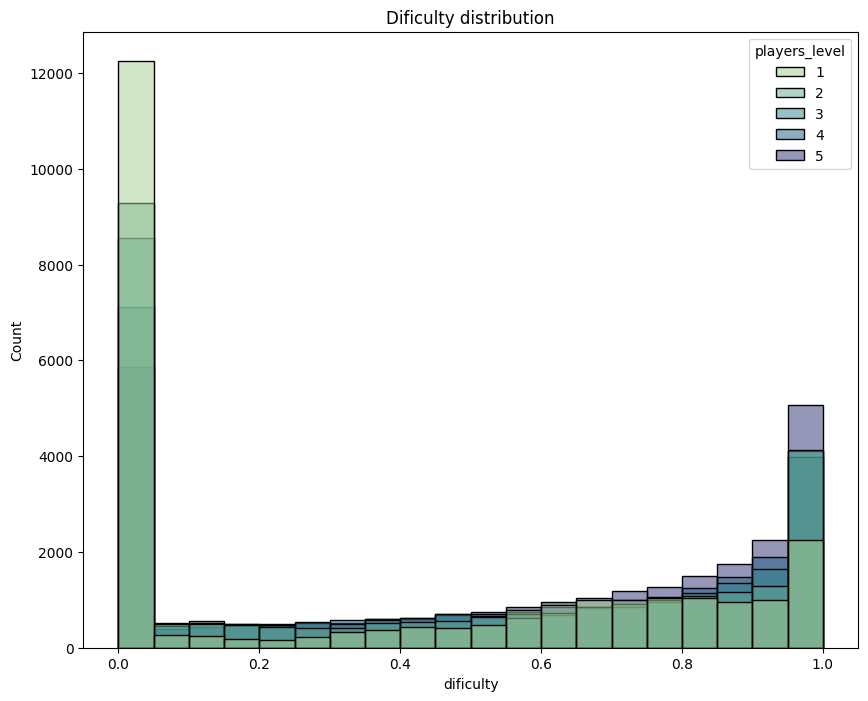

In [177]:
fig = plt.figure(figsize=(10, 8))
ax = sns.histplot(data=merged, x='dificulty', hue='players_level', bins=20, palette='crest');
ax.set_title('Dificulty distribution')

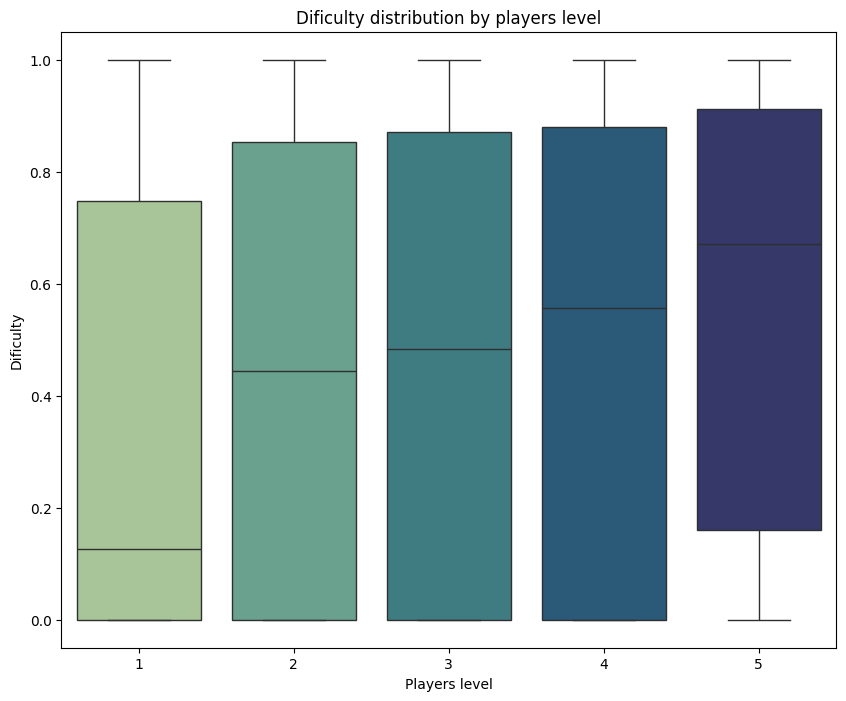

In [178]:
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=merged,x='players_level', y='dificulty', palette='crest', hue='players_level', legend=False);
ax.set_title('Dificulty distribution by players level')
ax.set_xlabel('Players level')
ax.set_ylabel('Dificulty');


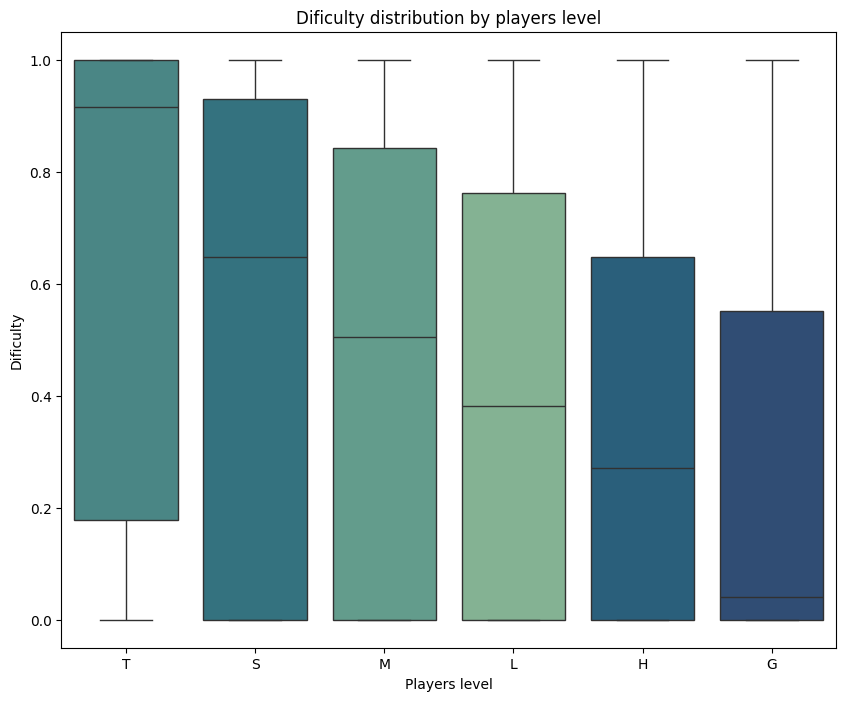

In [179]:
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=merged, x='monster_size', y='dificulty', palette='crest', hue='monster_size', legend=False, order=['T', 'S', 'M', 'L', 'H', 'G']);
ax.set_title('Dificulty distribution by players level')
ax.set_xlabel('Players level')
ax.set_ylabel('Dificulty');

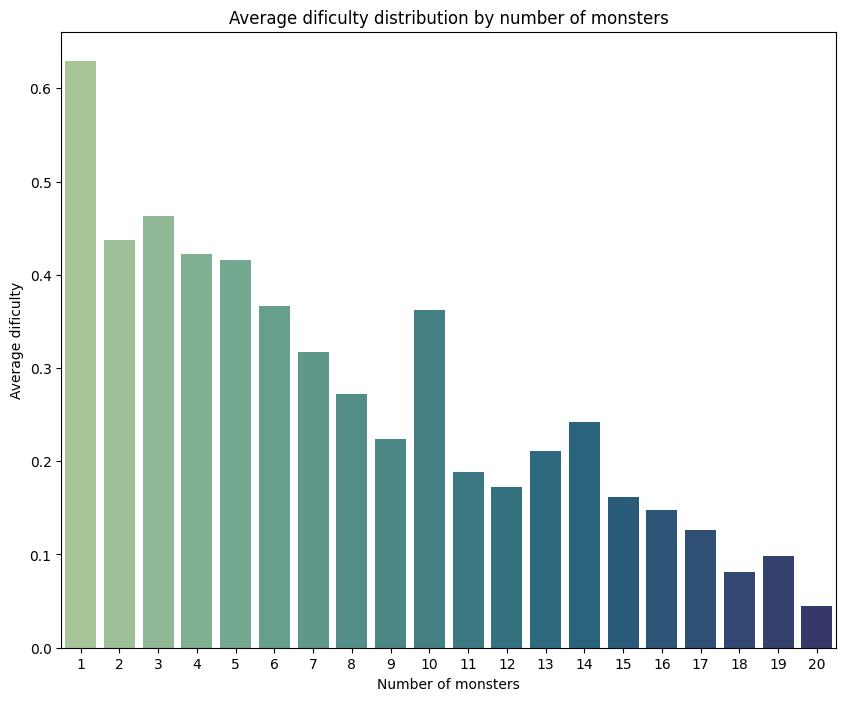

In [180]:
fig = plt.figure(figsize=(10, 8))
avg_dificulty = merged.groupby('num_of_monsters')['dificulty'].mean().reset_index()
ax = sns.barplot(data=avg_dificulty, x='num_of_monsters', y='dificulty', palette='crest', hue='num_of_monsters', legend=False);
ax.set_title('Average dificulty distribution by number of monsters')
ax.set_xlabel('Number of monsters')
ax.set_ylabel('Average dificulty');

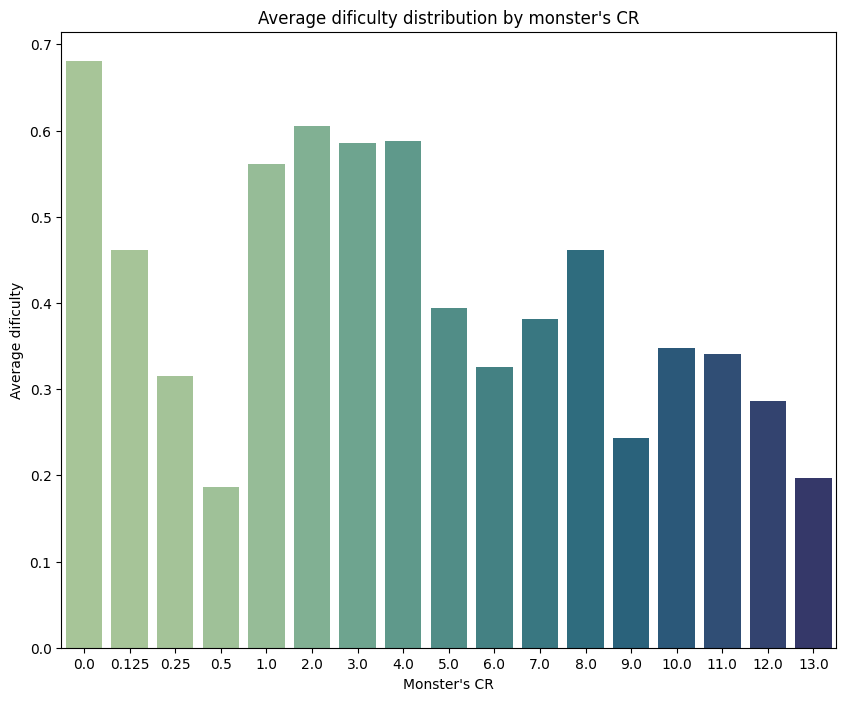

In [181]:
fig = plt.figure(figsize=(10, 8))
avg_dificulty = merged.groupby('monster_cr')['dificulty'].mean().reset_index()
ax = sns.barplot(data=avg_dificulty, x='monster_cr', y='dificulty', palette='crest', hue='monster_cr', legend=False);
ax.set_title("Average dificulty distribution by monster's CR")
ax.set_xlabel("Monster's CR")
ax.set_ylabel('Average dificulty');

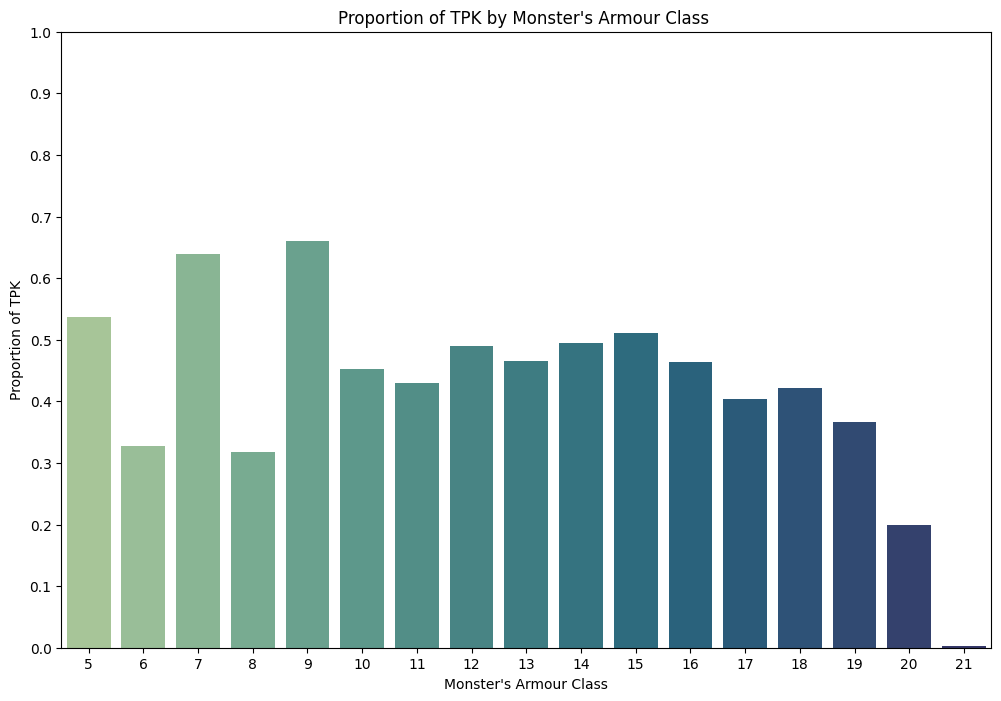

In [182]:
fig = plt.figure(figsize=(12, 8))
tpk_proportion = merged.groupby('monster_ac')['dificulty'].mean().reset_index()
ax = sns.barplot(data=tpk_proportion, x='monster_ac', y='dificulty', hue='monster_ac',palette='crest',legend=False)
plt.title("Proportion of TPK by Monster's Armour Class ")
plt.xlabel("Monster's Armour Class")
plt.ylabel('Proportion of TPK')
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


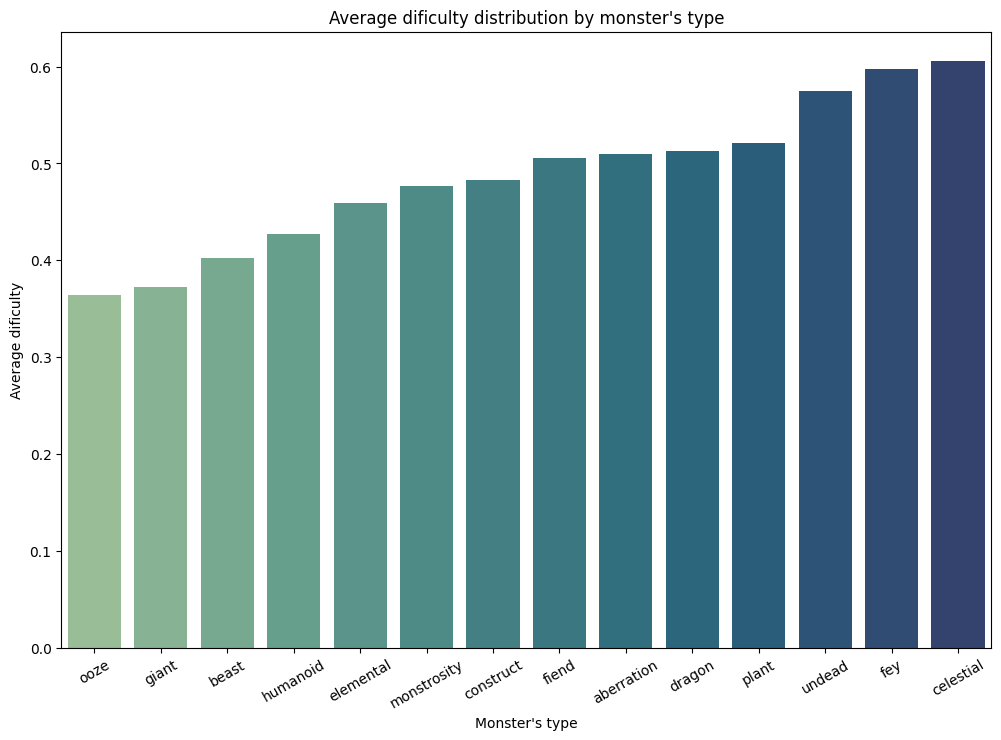

In [183]:
fig = plt.figure(figsize=(12, 8))
avg_dificulty = merged.groupby('monster_type')['dificulty'].mean().reset_index().sort_values(by='dificulty', ascending=True)
ax = sns.barplot(data=avg_dificulty, x='monster_type', y='dificulty', palette='crest', hue='monster_type', legend=False);
ax.set_title("Average dificulty distribution by monster's type")
ax.set_xlabel("Monster's type")
ax.set_ylabel('Average dificulty')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

Text(0, 0.5, 'Average dificulty')

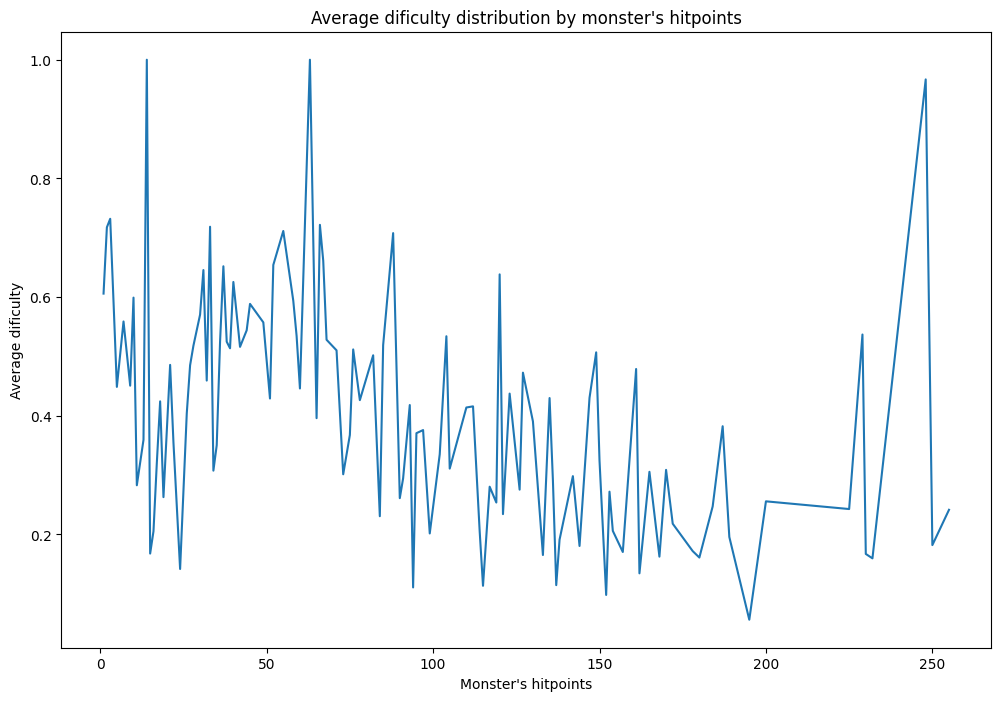

In [184]:
fig = plt.figure(figsize=(12, 8))
avg_dificulty = merged.groupby('monster_hp')['dificulty'].mean().reset_index()
ax = sns.lineplot(data=avg_dificulty, x='monster_hp', y='dificulty', legend=False);
ax.set_title("Average dificulty distribution by monster's hitpoints")
ax.set_xlabel("Monster's hitpoints")
ax.set_ylabel('Average dificulty')

## **Dividing the data into variables and target**

In [185]:
X = merged.drop(columns=['dificulty'])
Y = merged['dificulty'].copy()

## **One hot encoding the categorical data**

In [186]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 89 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     130856 non-null  int64  
 1   p1_ac                     130856 non-null  int64  
 2   p1_avg_save               130856 non-null  int64  
 3   p2_hp                     130856 non-null  int64  
 4   p2_ac                     130856 non-null  int64  
 5   p2_avg_save               130856 non-null  int64  
 6   p3_hp                     130856 non-null  int64  
 7   p3_ac                     130856 non-null  int64  
 8   p3_avg_save               130856 non-null  int64  
 9   p4_hp                     130856 non-null  int64  
 10  p4_ac                     130856 non-null  int64  
 11  p4_avg_save               130856 non-null  int64  
 12  num_of_monsters           130856 non-null  int64  
 13  monster_cr                130856 non-null  float6

In [187]:
test_features_df = encoder.transform(merged_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
df_test_encoded = pd.concat([merged_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     5732 non-null   int64  
 1   p1_ac                     5732 non-null   int64  
 2   p1_avg_save               5732 non-null   int64  
 3   p2_hp                     5732 non-null   int64  
 4   p2_ac                     5732 non-null   int64  
 5   p2_avg_save               5732 non-null   int64  
 6   p3_hp                     5732 non-null   int64  
 7   p3_ac                     5732 non-null   int64  
 8   p3_avg_save               5732 non-null   int64  
 9   p4_hp                     5732 non-null   int64  
 10  p4_ac                     5732 non-null   int64  
 11  p4_avg_save               5732 non-null   int64  
 12  num_of_monsters           5732 non-null   int64  
 13  monster_cr                5732 non-null   float64
 14  monster_ac   

In [188]:
print(Y.shape)
print(X_encoded.shape)

(130856,)
(130856, 89)


## **Splitting the dataset into the Training set and Test set**

In [189]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=.2)

# ***Building the model***

## **Making a rough model, without any hyperparameter tuning**

### *Training the model*

In [190]:

regXGB = XGBRegressor(eval_metric='rmse',early_stopping_rounds=10,)
regXGB.fit( X_train,
            Y_train,
            verbose=20,
            eval_set=[(X_train, Y_train),(X_test, Y_test)]
            );

[0]	validation_0-rmse:0.35039	validation_1-rmse:0.35060
[20]	validation_0-rmse:0.22329	validation_1-rmse:0.22608
[40]	validation_0-rmse:0.19891	validation_1-rmse:0.20453
[60]	validation_0-rmse:0.18327	validation_1-rmse:0.19197
[80]	validation_0-rmse:0.17030	validation_1-rmse:0.18155
[99]	validation_0-rmse:0.16198	validation_1-rmse:0.17502


### *Looking at the model results*

In [191]:
title = 'Raw XGBoost'

#### Model scores on the test set

In [192]:
print_regression_report(X_test,Y_test,regXGB,title)

Raw XGBoost
Mean Squared Error:		 0.029434721764906913
Mean Absolute Error:		 0.12154730077834429
R²:				 0.8129082194204583
Root Mean Squared Error:	 0.17156550284048047


#### Model resisuals distribution

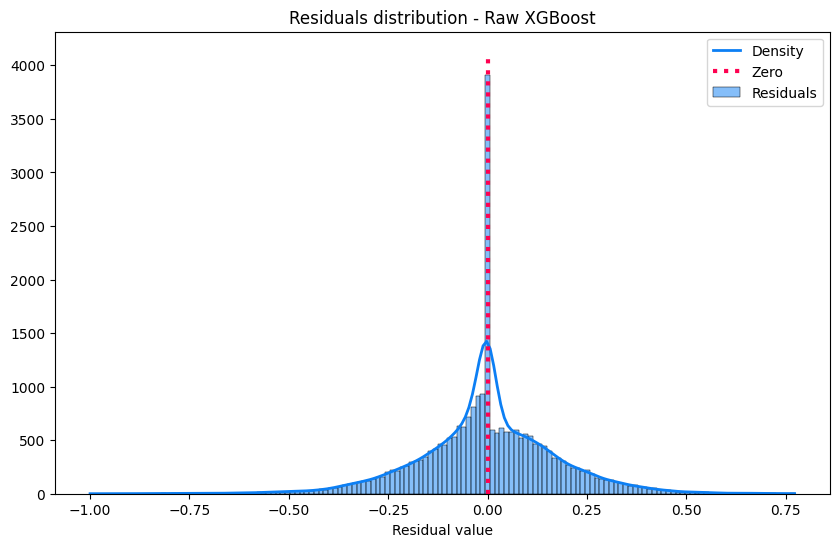

In [193]:
plot_residual_distribution(X_test, Y_test, regXGB, title)

#### Model resisuals vs true values

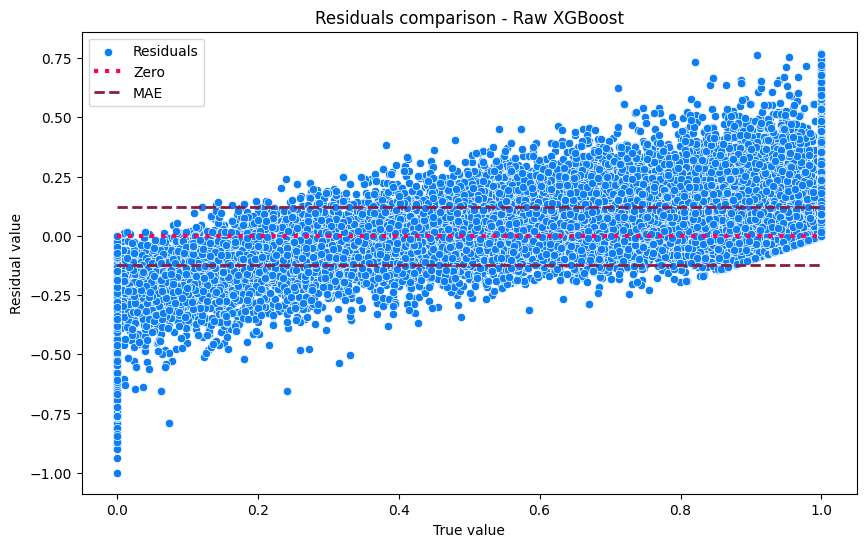

In [194]:
plot_residual_comparison(X_test, Y_test, regXGB, title)

#### Model features importance (SHAP values)

[19:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


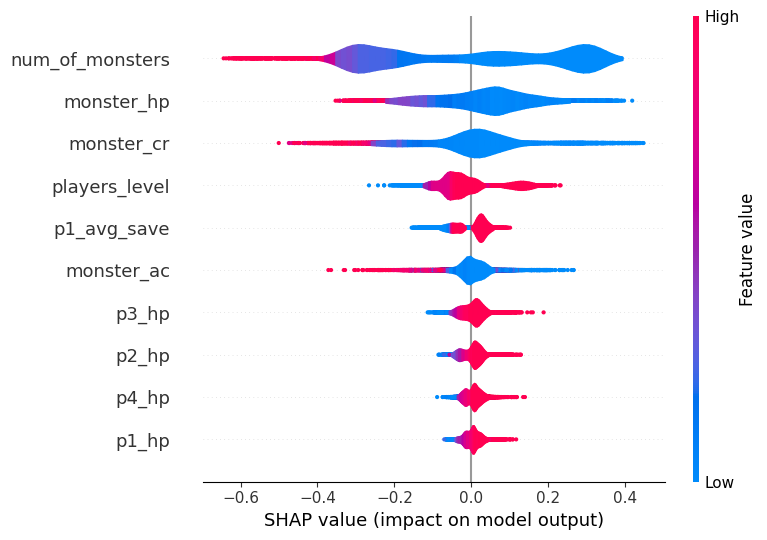

In [195]:
plot_feature_importance(regXGB, X_test);

### *Predicting the using the model*

In [196]:
predict(regXGB, X_test, Y_test)

Input: 
The combat was between 4 players level 4 against 2 monster(s) CR 8.0
Expected:  0.0
Predicted:  0.10120626
Delta: 0.1


## **Hyperparameter tuning using ``Optuna``**

### *Defining the objective function*

In [197]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)
    base_score = trial.suggest_float('base_score', 0.2, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        base_score=base_score,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train, Y_train),(X_test, Y_test)]
        )
    
    model.fit(
        X_train,
        Y_train,
        verbose=False
        )
    Y_pred = truncate_prediction(model, X_test)
    return mean_squared_error(Y_test, Y_pred)

### *Training the model's hyperparameters*

In [198]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1) # type: ignore
study.best_params

[I 2023-12-18 19:26:42,007] A new study created in memory with name: regression
[I 2023-12-18 19:26:45,370] Trial 3 finished with value: 0.07400880448941627 and parameters: {'n_estimators': 58, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.1, 'min_child_weight': 1, 'colsample_bytree': 0.5, 'base_score': 0.2}. Best is trial 3 with value: 0.07400880448941627.
[I 2023-12-18 19:26:46,289] Trial 4 finished with value: 0.06863932450353548 and parameters: {'n_estimators': 57, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'min_child_weight': 7, 'colsample_bytree': 0.3, 'base_score': 0.5}. Best is trial 4 with value: 0.06863932450353548.
[I 2023-12-18 19:26:46,804] Trial 10 finished with value: 0.05243474886516303 and parameters: {'n_estimators': 62, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.3, 'min_child_weight': 3, 'colsample_bytree': 0.4, 'base_score': 0.6000000000000001}. Best is trial 10 with value: 0.05243474886516303.
[I 2023-12-18 19:26:48,576] Trial 6 fi

{'n_estimators': 196,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 2,
 'colsample_bytree': 0.4,
 'base_score': 0.7}

### *Model's best hyperparameters*

In [199]:
# FINAL_PARAMETERS_OPT = study.best_params
FINAL_PARAMETERS_OPT = {
  'n_estimators': 200,
  'max_depth': 7,
  'learning_rate': 0.2,
  'gamma': 0.0,
  'min_child_weight': 6,
  'colsample_bytree': 0.7,
  'base_score': 0.6
}

### *Making the regression model*

In [200]:
model_OPT = XGBRegressor(**FINAL_PARAMETERS_OPT,early_stopping_rounds=10,eval_metric='rmse')
model_OPT.fit(  
            X_train,
            Y_train,
            eval_set=[(X_train, Y_train),(X_test, Y_test)],
            verbose=20
          );

[0]	validation_0-rmse:0.37837	validation_1-rmse:0.37849
[20]	validation_0-rmse:0.22203	validation_1-rmse:0.22532
[40]	validation_0-rmse:0.20214	validation_1-rmse:0.20952
[60]	validation_0-rmse:0.18445	validation_1-rmse:0.19475
[80]	validation_0-rmse:0.17442	validation_1-rmse:0.18742
[100]	validation_0-rmse:0.16417	validation_1-rmse:0.17974
[120]	validation_0-rmse:0.15576	validation_1-rmse:0.17340
[140]	validation_0-rmse:0.14893	validation_1-rmse:0.16882
[160]	validation_0-rmse:0.14414	validation_1-rmse:0.16534
[180]	validation_0-rmse:0.13811	validation_1-rmse:0.16129
[199]	validation_0-rmse:0.13464	validation_1-rmse:0.15932


### *Looking at the model results*

In [201]:
title = 'XGBoost with Optuna'

#### Model scores on the test set

In [202]:
print_regression_report(X_test,Y_test,model_OPT,title)

XGBoost with Optuna
Mean Squared Error:		 0.02426693646483453
Mean Absolute Error:		 0.10720369780993787
R²:				 0.8457554860318259
Root Mean Squared Error:	 0.15577848524374133


#### Model resisuals distribution

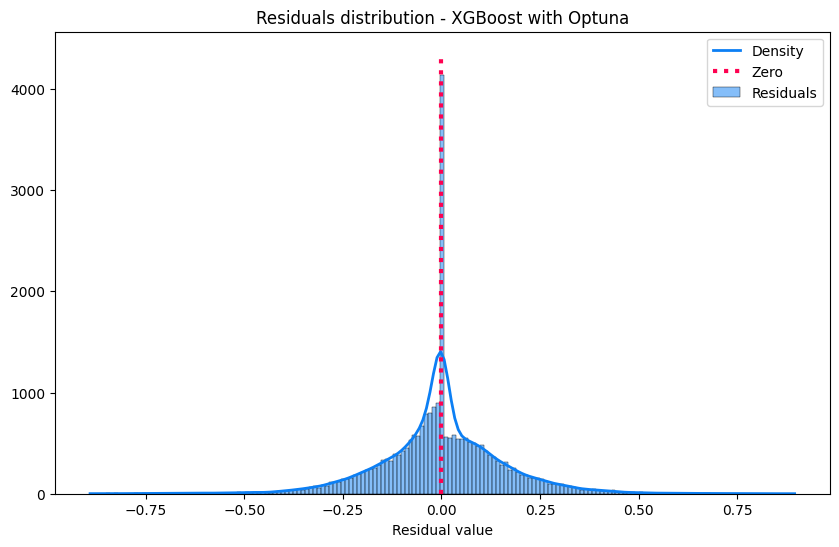

In [203]:
plot_residual_distribution(X_test, Y_test, model_OPT, title);

#### Model resisuals vs true values

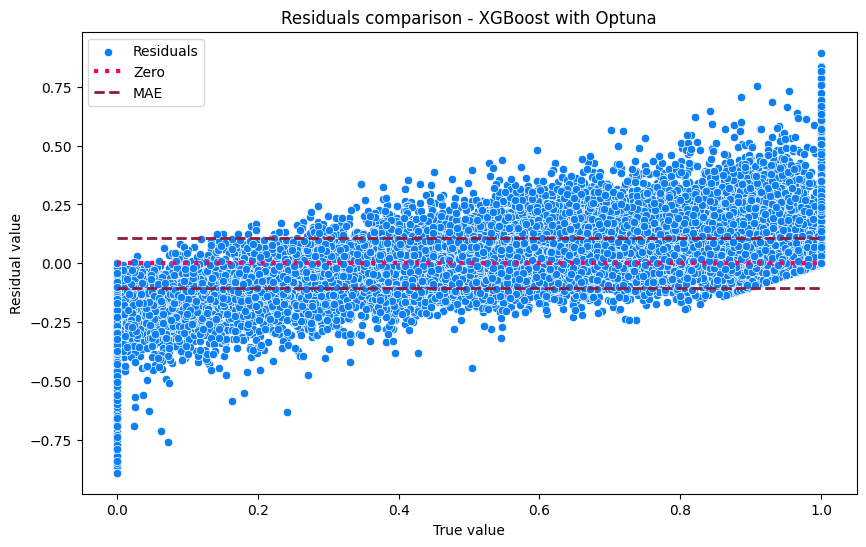

In [204]:
plot_residual_comparison(X_test, Y_test, model_OPT, title);

#### Model features importance (SHAP values)

[19:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


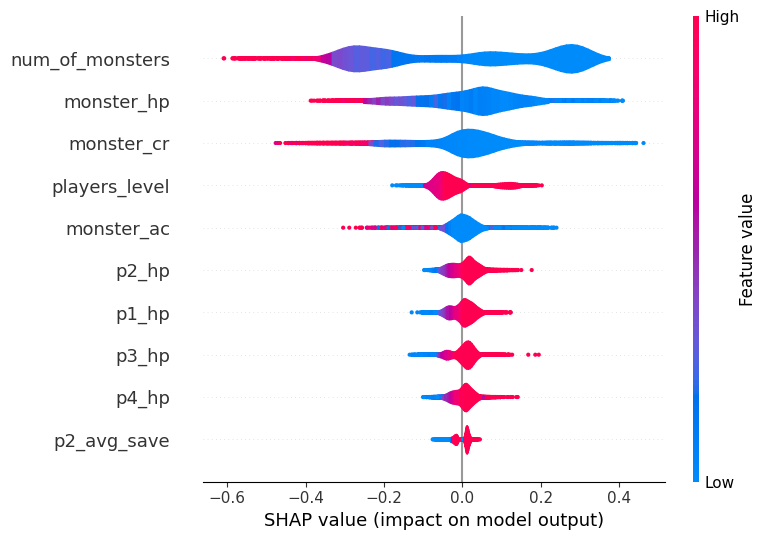

In [205]:
plot_feature_importance(model_OPT, X_test);

### *Making predictions*

In [206]:
predict(model_OPT, X_test, Y_test)

Input: 
The combat was between 4 players level 3 against 2 monster(s) CR 6.0
Expected:  0.0
Predicted:  0.0
Delta: 0.0


## **Scaling the data with ``StandardScaler`` beforehand**

### *Scaling the data*

In [207]:
scaler = StandardScaler()

scaler.fit(X_encoded)
X_encoded_scaled = scaler.transform(X_encoded)
df_test_encoded_scaled = scaler.transform(df_test_encoded)
X_encoded_scaled = pd.DataFrame(X_encoded_scaled, columns=X_encoded.columns)
df_test_encoded_scaled = pd.DataFrame(df_test_encoded_scaled, columns=df_test_encoded.columns)

### *Splitting the dataset into the Training set and Test set*

In [208]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_encoded_scaled, Y, test_size=.2)

### *Defining the objective function*

In [209]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)
    base_score = trial.suggest_float('base_score', 0.2, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        base_score=base_score,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train_scaled, Y_train_scaled),(X_test_scaled, Y_test_scaled)]
        )
    
    model.fit(
        X_train_scaled,
        Y_train_scaled,
        verbose=False
        )
    Y_pred = truncate_prediction(model, X_test_scaled)
    return mean_squared_error(Y_test_scaled, Y_pred)

### *Training the model's hyperparameters*

In [210]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1) # type: ignore
study.best_params

[I 2023-12-18 19:30:14,541] A new study created in memory with name: regression
[I 2023-12-18 19:30:17,562] Trial 4 finished with value: 0.06817729998412168 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'min_child_weight': 7, 'colsample_bytree': 0.7, 'base_score': 0.6000000000000001}. Best is trial 4 with value: 0.06817729998412168.
[I 2023-12-18 19:30:18,127] Trial 3 finished with value: 0.0774585912037103 and parameters: {'n_estimators': 74, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'min_child_weight': 3, 'colsample_bytree': 0.4, 'base_score': 0.2}. Best is trial 4 with value: 0.06817729998412168.
[I 2023-12-18 19:30:19,792] Trial 2 finished with value: 0.059656605975002094 and parameters: {'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'min_child_weight': 4, 'colsample_bytree': 0.7, 'base_score': 0.30000000000000004}. Best is trial 2 with value: 0.059656605975002094.
[I 2023-12-18 19:30:21,426] Trial 12 f

{'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 3,
 'colsample_bytree': 0.5,
 'base_score': 0.30000000000000004}

#### Model's best hyperparameters

In [211]:
# FINAL_PARAMETERS_OPT_SCALED = study.best_params
FINAL_PARAMETERS_OPT_SCALED={
  'n_estimators': 196,
  'max_depth': 7,
  'learning_rate': 0.2,
  'gamma': 0.0,
  'min_child_weight': 6,
  'colsample_bytree': 0.5,
  'base_score': 0.2
}

### *Training the Regression model*

In [212]:
model_OPT_SCALED = XGBRegressor(**FINAL_PARAMETERS_OPT_SCALED, early_stopping_rounds=10,eval_metric='rmse')
model_OPT_SCALED.fit(
            X_train_scaled,
            Y_train_scaled,
            eval_set=[(X_train_scaled, Y_train_scaled),(X_test_scaled, Y_test_scaled)],
            verbose=20
          );

[0]	validation_0-rmse:0.44507	validation_1-rmse:0.44414
[20]	validation_0-rmse:0.23040	validation_1-rmse:0.23235
[40]	validation_0-rmse:0.20550	validation_1-rmse:0.21087
[60]	validation_0-rmse:0.19171	validation_1-rmse:0.20002
[80]	validation_0-rmse:0.17853	validation_1-rmse:0.18962
[100]	validation_0-rmse:0.16986	validation_1-rmse:0.18366
[120]	validation_0-rmse:0.16279	validation_1-rmse:0.17856
[140]	validation_0-rmse:0.15392	validation_1-rmse:0.17214
[160]	validation_0-rmse:0.14851	validation_1-rmse:0.16868
[180]	validation_0-rmse:0.14415	validation_1-rmse:0.16576
[195]	validation_0-rmse:0.13927	validation_1-rmse:0.16224


### *Looking at the model results*

In [213]:
title = 'XGBoost with Optuna and Scaled Data'

#### Model scores on the test set

In [214]:
print_regression_report(X_test_scaled,Y_test_scaled,model_OPT_SCALED,title)

XGBoost with Optuna and Scaled Data
Mean Squared Error:		 0.02525657579177385
Mean Absolute Error:		 0.11029983429800838
R²:				 0.839332394021413
Root Mean Squared Error:	 0.15892317575411666


#### Model's resisuals distribution

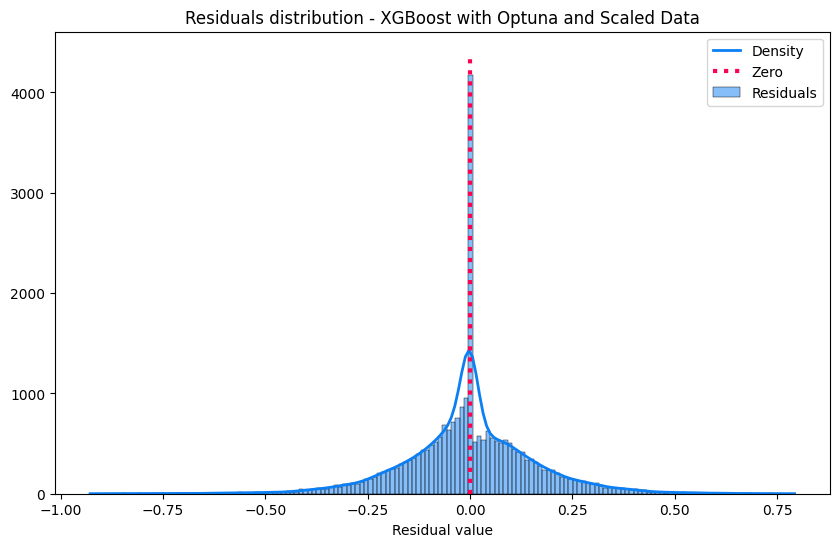

In [215]:
plot_residual_distribution(X_test_scaled, Y_test_scaled, model_OPT_SCALED, title);

#### Model's resisuals vs true values

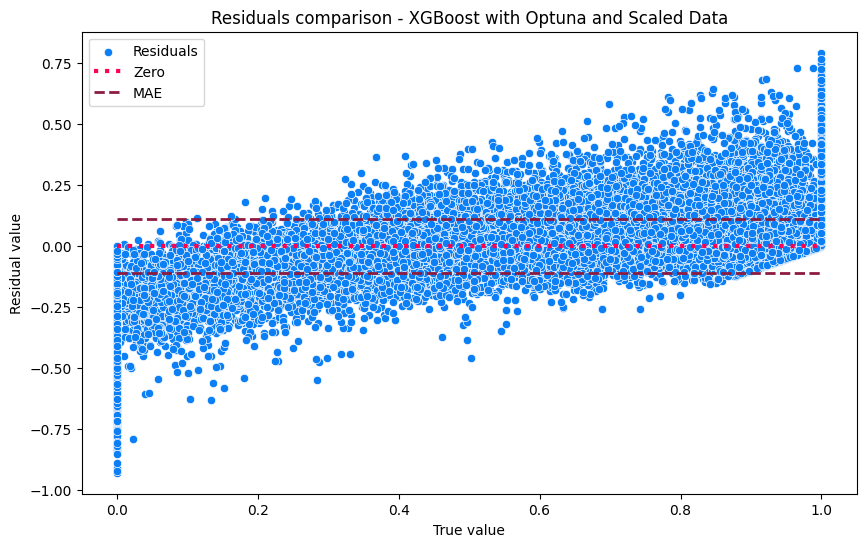

In [216]:
plot_residual_comparison(X_test_scaled, Y_test_scaled, model_OPT_SCALED, title);

#### Model features importance (SHAP values)

[19:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


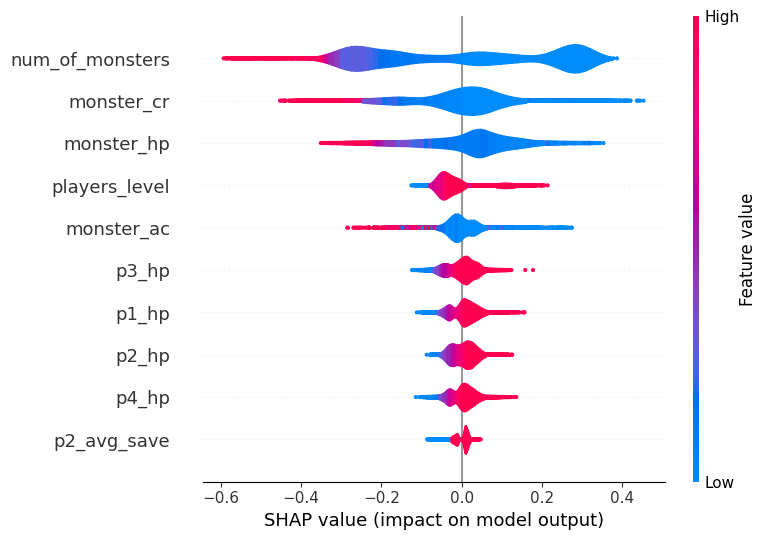

In [217]:
plot_feature_importance(model_OPT_SCALED, X_test_scaled);

### *Making predictions*

In [218]:
predict(model_OPT_SCALED, X_test_scaled, Y_test_scaled, scaler=scaler)

Input: 
The combat was between 4 players level 1 against 10 monster(s) CR 0.125
Expected:  0.0
Predicted:  0.0
Delta: 0.0


## **Normalizing the data with ``MinMaxScaller`` beforehand**

### *Normalizing the data*

In [219]:
normalizer = MinMaxScaler()

normalizer.fit(X_encoded)
X_encoded_normalized = normalizer.transform(X_encoded)
df_test_encoded_nomalized = normalizer.transform(df_test_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)
df_test_encoded_nomalized = pd.DataFrame(df_test_encoded_nomalized, columns=df_test_encoded.columns)

### *Splitting the dataset into the Training set and Test set*

In [220]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=.2)

### *Defining the objective function*

In [221]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)
    base_score = trial.suggest_float('base_score', 0.2, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        base_score=base_score,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train_normalized, Y_train_normalized),(X_test_normalized, Y_test_normalized)]
        )
    
    model.fit(
        X_train_normalized,
        Y_train_normalized,
        verbose=False
        )
    Y_pred = truncate_prediction(model, X_test_normalized)
    return mean_squared_error(Y_test_normalized, Y_pred)

### *Training the model's hyperparameters*

In [222]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1) # type: ignore
study.best_params

[I 2023-12-18 19:33:39,403] A new study created in memory with name: regression
[I 2023-12-18 19:33:43,955] Trial 2 finished with value: 0.080127913336542 and parameters: {'n_estimators': 107, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'min_child_weight': 4, 'colsample_bytree': 0.7, 'base_score': 0.30000000000000004}. Best is trial 2 with value: 0.080127913336542.
[I 2023-12-18 19:33:44,494] Trial 1 finished with value: 0.04680280233889552 and parameters: {'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'base_score': 0.2}. Best is trial 1 with value: 0.04680280233889552.
[I 2023-12-18 19:33:44,744] Trial 4 finished with value: 0.04979264993997572 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.0, 'min_child_weight': 4, 'colsample_bytree': 0.5, 'base_score': 0.2}. Best is trial 1 with value: 0.04680280233889552.
[I 2023-12-18 19:33:45,000] Trial 5 finished with value: 

{'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 1,
 'colsample_bytree': 0.7,
 'base_score': 0.5}

#### Model's best hyperparameters

In [223]:
# FINAL_PARAMETERS_OPT_NORMALIZED = study.best_params
FINAL_PARAMETERS_OPT_NORMALIZED={
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.0,
    'min_child_weight': 7,
    'colsample_bytree': 0.4,
    'base_score': 0.7
}

### *Training the Regression model*

In [224]:
model_OPT_NORMALIZED = XGBRegressor(**FINAL_PARAMETERS_OPT_NORMALIZED, early_stopping_rounds=10,eval_metric='rmse')
model_OPT_NORMALIZED.fit(
            X_train_normalized,
            Y_train_normalized,
            eval_set=[(X_train_normalized, Y_train_normalized),(X_test_normalized, Y_test_normalized)],
            verbose=20
          );

[0]	validation_0-rmse:0.43238	validation_1-rmse:0.43475


[20]	validation_0-rmse:0.23740	validation_1-rmse:0.24374
[40]	validation_0-rmse:0.20514	validation_1-rmse:0.21387
[60]	validation_0-rmse:0.19125	validation_1-rmse:0.20296
[80]	validation_0-rmse:0.17888	validation_1-rmse:0.19282
[100]	validation_0-rmse:0.17068	validation_1-rmse:0.18704
[120]	validation_0-rmse:0.16519	validation_1-rmse:0.18335
[140]	validation_0-rmse:0.15829	validation_1-rmse:0.17823
[160]	validation_0-rmse:0.15210	validation_1-rmse:0.17362
[180]	validation_0-rmse:0.14788	validation_1-rmse:0.17065
[199]	validation_0-rmse:0.14274	validation_1-rmse:0.16674


### *Looking at the model results*

In [225]:
title = 'XGBoost with Optuna and Normalized Data'

#### Model scores on the test set

In [226]:
print_regression_report(X_test_normalized,Y_test_normalized,model_OPT_NORMALIZED,title)

XGBoost with Optuna and Normalized Data
Mean Squared Error:		 0.02675119677578122
Mean Absolute Error:		 0.11448455028118154
R²:				 0.82973892563721
Root Mean Squared Error:	 0.1635579309473595


#### Model's resisuals distribution

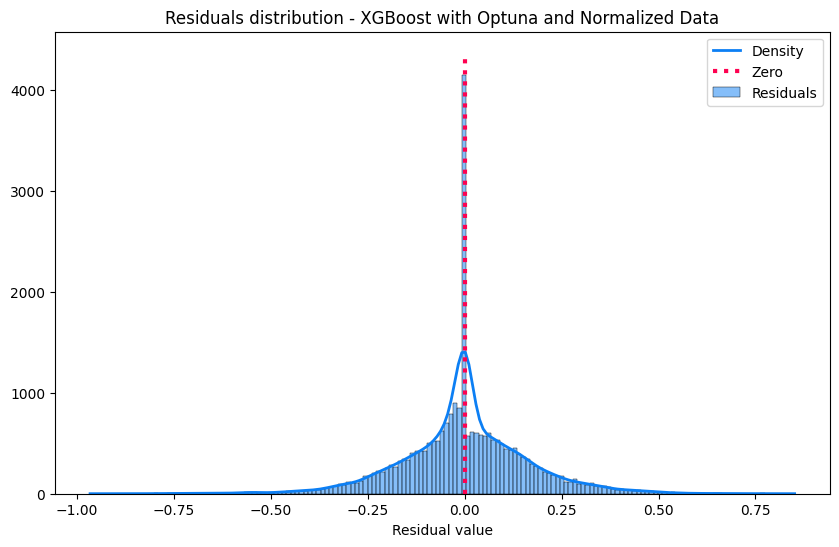

In [227]:
plot_residual_distribution(X_test_normalized, Y_test_normalized, model_OPT_NORMALIZED, title);

#### Model's resisuals vs true values

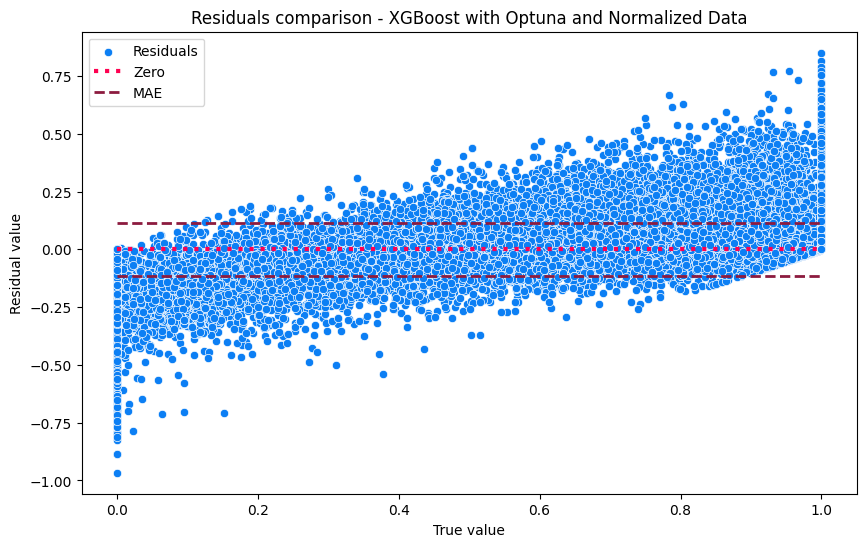

In [228]:
plot_residual_comparison(X_test_normalized, Y_test_normalized, model_OPT_NORMALIZED, title);

#### Model features importance (SHAP values)

[19:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


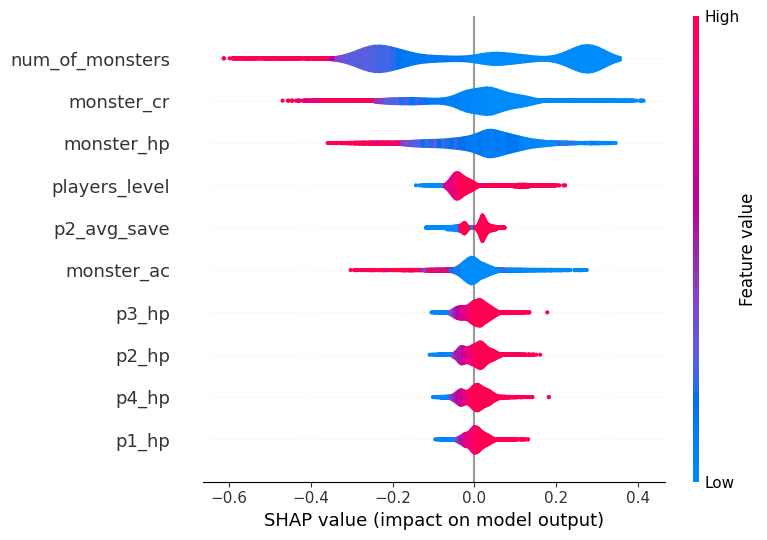

In [229]:
plot_feature_importance(model_OPT_NORMALIZED, X_test_normalized);

### *Making predictions*

In [230]:
predict(model_OPT_NORMALIZED, X_test_normalized, Y_test_normalized, normalizer=normalizer)

Input: 
The combat was between 4 players level 2 against 1 monster(s) CR 5.0
Expected:  0.4646335583413694
Predicted:  0.27352783
Delta: 0.19


# ***Comparing all four models***

## **Comparing the models metrics**

### *Creating the dataframe with all models results*

In [231]:
results = {
    'Raw XGBoost': {
        'R2': r2_score(Y_test, truncate_prediction(regXGB, X_test)),
        'RMSE': np.sqrt(mean_squared_error(Y_test, truncate_prediction(regXGB, X_test))),
        'MSE': mean_squared_error(Y_test, truncate_prediction(regXGB, X_test)),
        'MAE': mean_absolute_error(Y_test, truncate_prediction(regXGB, X_test))
    },
    'XGBoost with Optuna': {
        'R2': r2_score(Y_test, truncate_prediction(model_OPT, X_test)),
        'RMSE': np.sqrt(mean_squared_error(Y_test, truncate_prediction(model_OPT, X_test))),
        'MSE': mean_squared_error(Y_test, truncate_prediction(model_OPT, X_test)),
        'MAE': mean_absolute_error(Y_test, truncate_prediction(model_OPT, X_test))
    },
    'XGBoost with Optuna and Scaled Data': {
        'R2': r2_score(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled)),
        'RMSE': np.sqrt(mean_squared_error(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled))),
        'MSE': mean_squared_error(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled)),
        'MAE': mean_absolute_error(Y_test_scaled, truncate_prediction(model_OPT_SCALED, X_test_scaled))
    },
    'XGBoost with Optuna and Normalized Data': {
        'R2': r2_score(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized)),
        'RMSE': np.sqrt(mean_squared_error(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized))),
        'MSE': mean_squared_error(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized)),
        'MAE': mean_absolute_error(Y_test_normalized, truncate_prediction(model_OPT_NORMALIZED, X_test_normalized))
    }
}

### *Comparing the models*

In [232]:
models_metrics = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
models_metrics

R2      RMSE       MSE  \
XGBoost with Optuna                      0.845755  0.155778  0.024267   
XGBoost with Optuna and Scaled Data      0.839332  0.158923  0.025257   
XGBoost with Optuna and Normalized Data  0.829739  0.163558  0.026751   
Raw XGBoost                              0.812908  0.171566  0.029435   

                                              MAE  
XGBoost with Optuna                      0.107204  
XGBoost with Optuna and Scaled Data      0.110300  
XGBoost with Optuna and Normalized Data  0.114485  
Raw XGBoost                              0.121547

## **Comparing models behaviors**

In [233]:
models = [[{'Raw XGBoost':[regXGB,X_test,Y_test]}, {'XGBoost with Optune':[model_OPT,X_test,Y_test]}],[{'XGBoost with Optune and Scaled':[model_OPT_SCALED,X_test_scaled,Y_test_scaled]}, {'XGBoost with Optune and Normalized':[model_OPT_NORMALIZED,X_test_normalized,Y_test_normalized]}]]

### *Comparing the models residuals distributions*

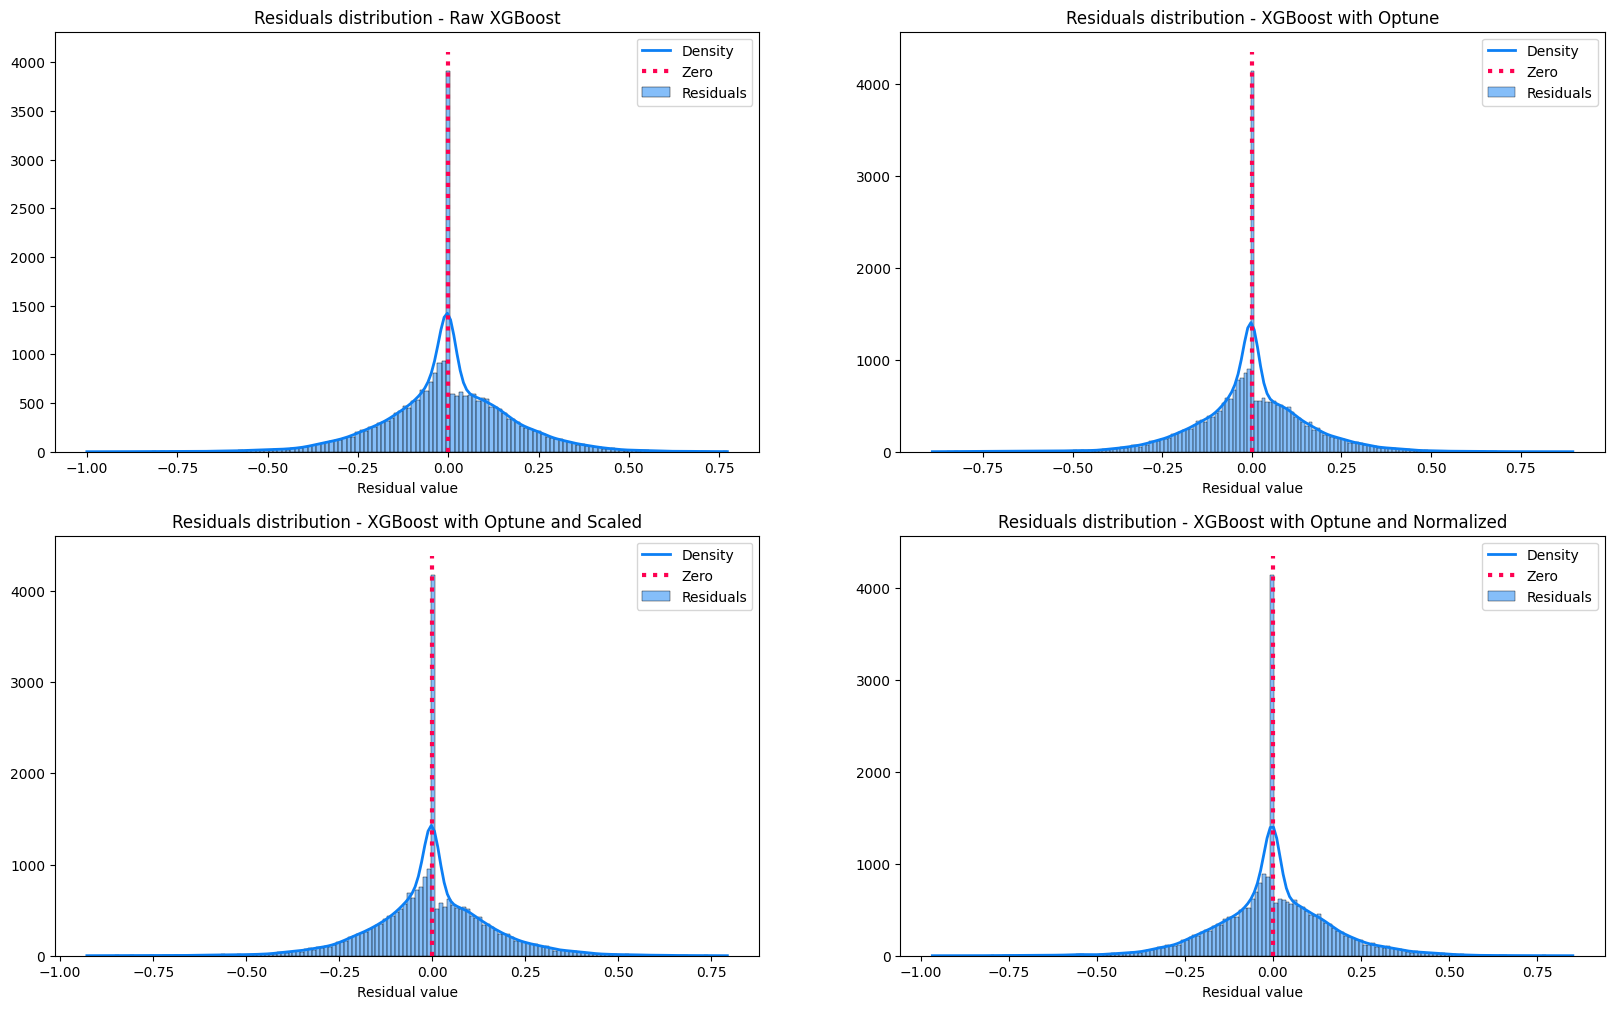

In [234]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        Y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.histplot(Y_test - truncate_prediction(model,x_test), color=COLORS[2], kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'}, ax=axes[i][j])
        axes[i][j].set_title(f'Residuals distribution - {title}')
        axes[i][j].set_xlabel('Residual value')
        axes[i][j].set_ylabel('')
        axes[i][j].vlines(0, axes[i][j].get_ylim()[0], axes[i][j].get_ylim()[1], colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        axes[i][j].legend();



### *Changing the y axis scale*

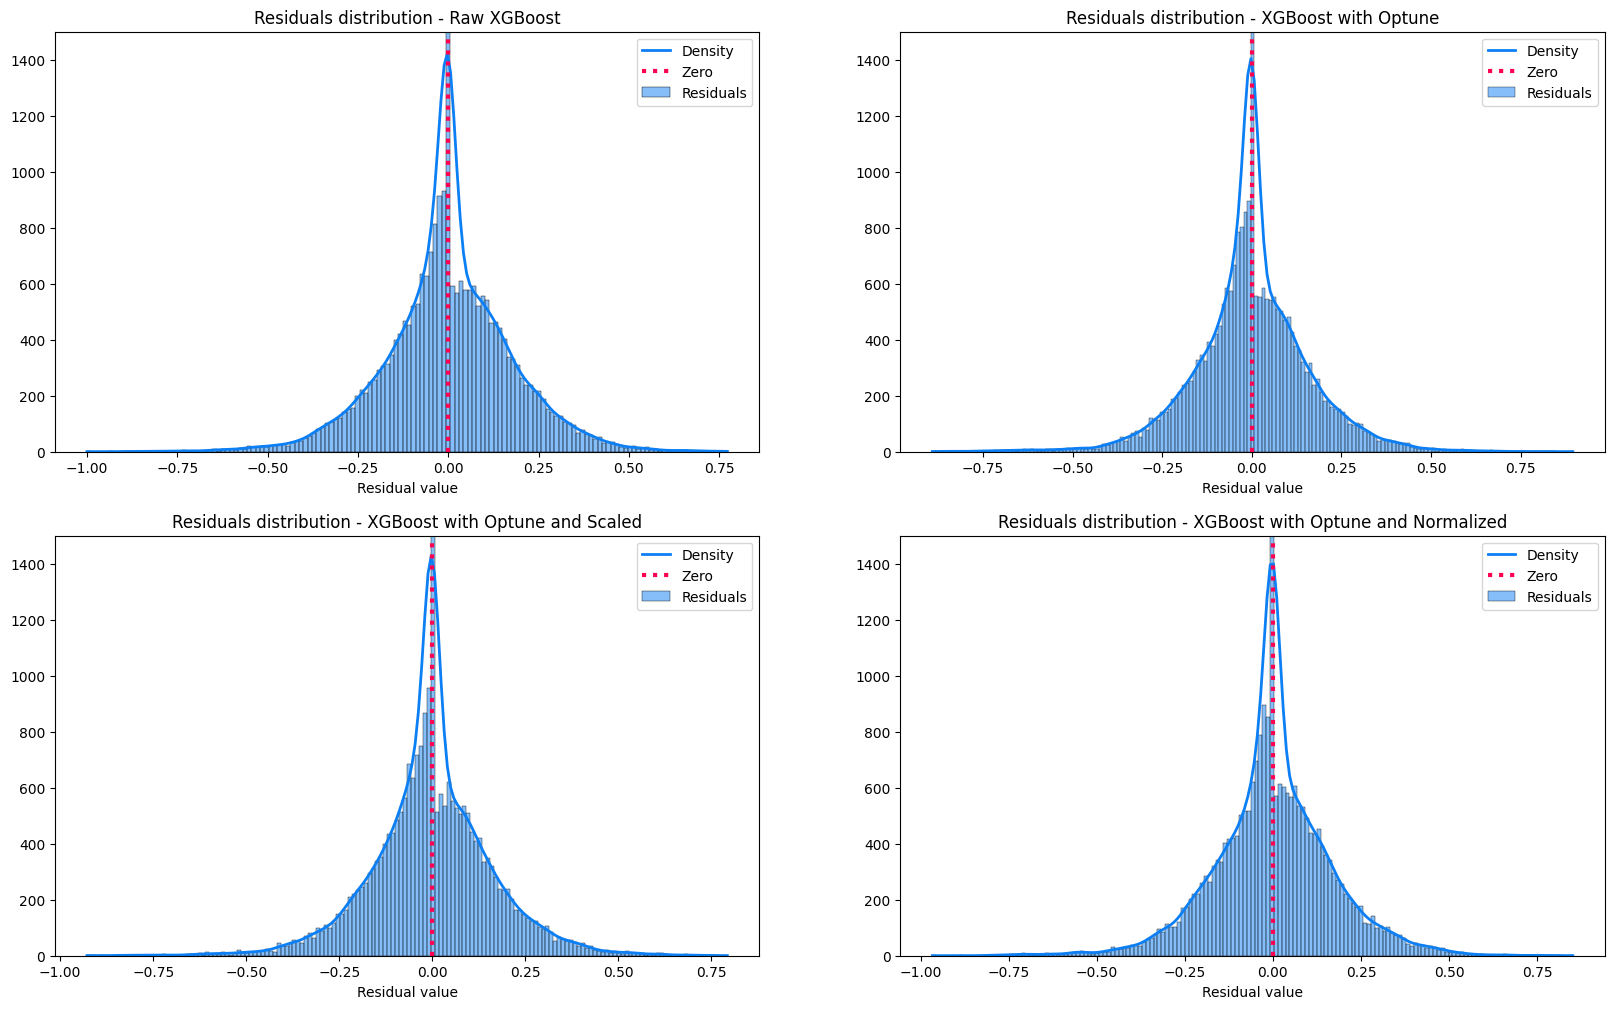

In [235]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        Y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.histplot(Y_test - truncate_prediction(model,x_test), color=COLORS[2], kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'}, ax=axes[i][j])
        axes[i][j].set_title(f'Residuals distribution - {title}')
        axes[i][j].set_xlabel('Residual value')
        axes[i][j].set_ylabel('')
        axes[i][j].set_ylim(0, 1500)
        axes[i][j].vlines(0, axes[i][j].get_ylim()[0], axes[i][j].get_ylim()[1], colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        axes[i][j].legend();



### *Comparing the models residuals vs true values*

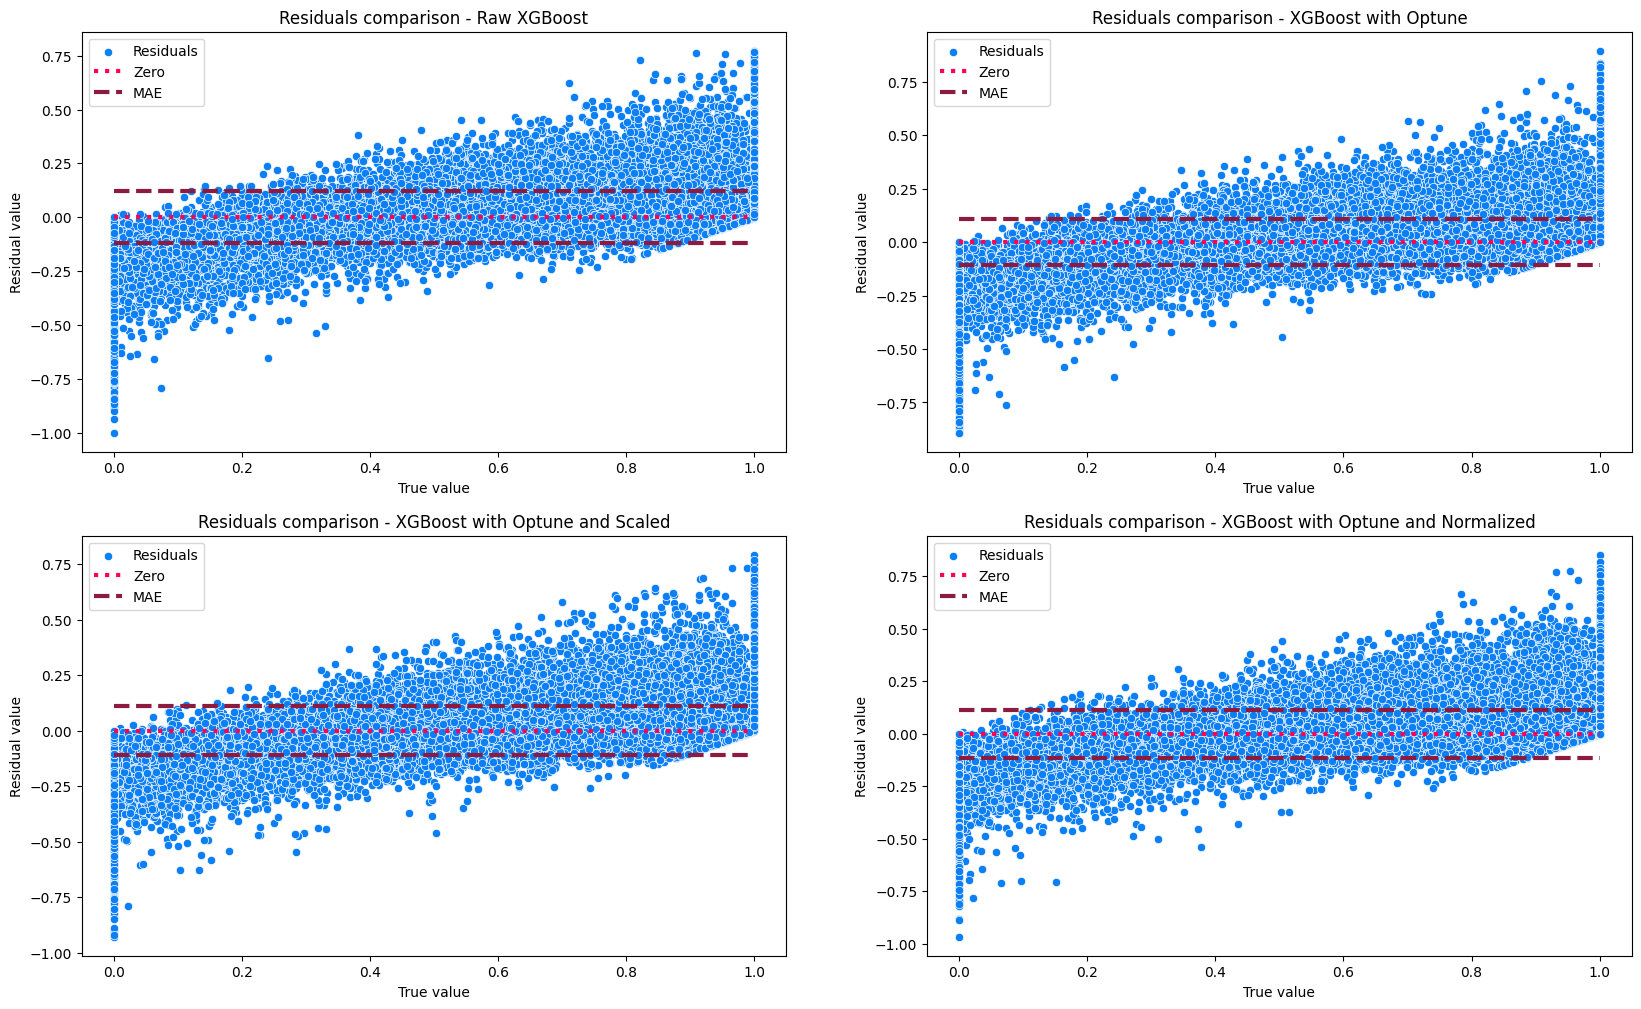

In [236]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.scatterplot(x=y_test, y=y_test-truncate_prediction(model,x_test), color=COLORS[2], label='Residuals',ax=ax)
        ax.set_title(f'Residuals comparison - {title}')
        ax.set_xlabel('True value')
        ax.set_ylabel('Residual value')
        ax.hlines(0, 0, 1, colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        ax.hlines(mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', label='MAE', linewidth=3)
        ax.hlines(-mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', linewidth=3)
        ax.legend();

### *Changing the scale to try and focus on the error*

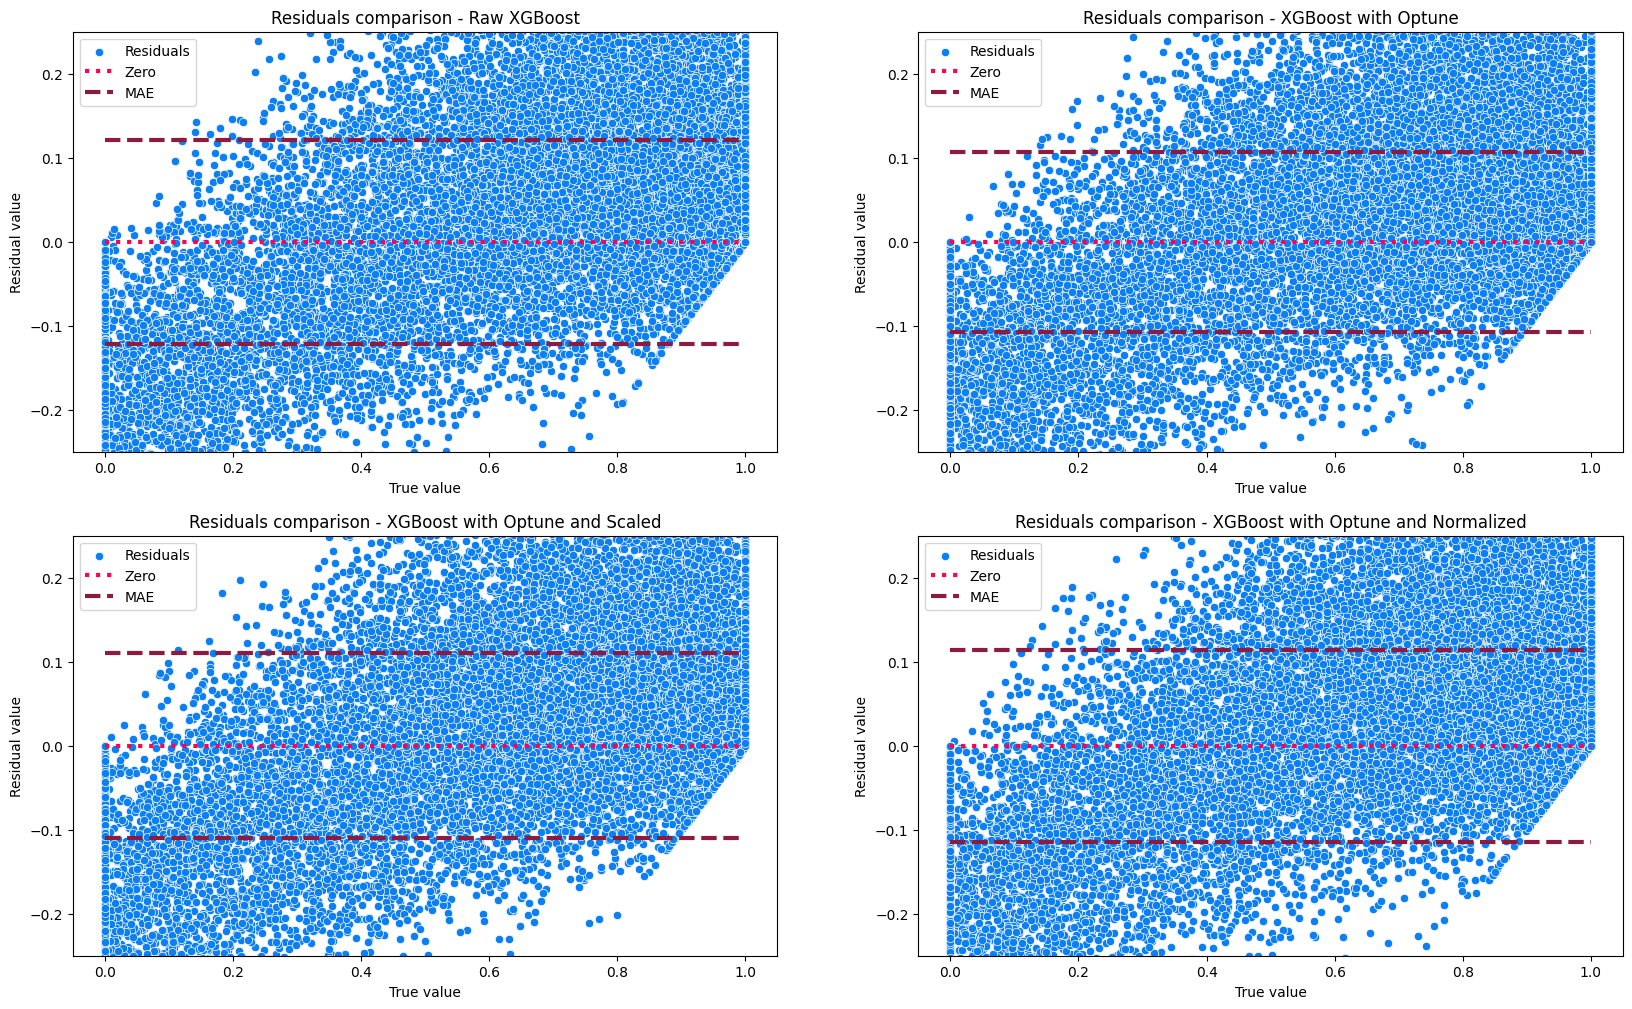

In [237]:
fig, axes = plt.subplots(2,2,figsize=(20, 12))

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        model = list(models[i][j].values())[0][0]
        x_test = list(models[i][j].values())[0][1]
        y_test = list(models[i][j].values())[0][2]
        title = list(models[i][j].keys())[0]
        sns.scatterplot(x=y_test, y=y_test-truncate_prediction(model,x_test), color=COLORS[2], label='Residuals',ax=ax)
        ax.set_title(f'Residuals comparison - {title}')
        ax.set_xlabel('True value')
        ax.set_ylabel('Residual value')
        ax.set_ylim(-0.25, 0.25)
        ax.hlines(0, 0, 1, colors=COLORS[1], linestyles=':', label='Zero', linewidth=3)
        ax.hlines(mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', label='MAE', linewidth=3)
        ax.hlines(-mean_absolute_error(y_test, truncate_prediction(model, x_test)), 0, 1, colors=COLORS[0], linestyles='--', linewidth=3)
        ax.legend();

# ***Saving the best model***

In [238]:
model_OPT.save_model('../Model/Regreesion_XGBoost_OPT_v2.ubj')